# Big Data Project - DE3 - 2021
_Julian MOTYL, Quentin THIZY, et Kent BRUDEY_

**Création d'un script d'apprentissage automatique de classification supervisée déterminant à partir d'un extrait de CV, le métier du titulaire parmis 28 catégories de métiers.**

`Entrées` :


*   _categories_string.csv_ => **job, id_job**
*   _categories_label.csv_ => **id_cv, id_job**
*   _data.json_ => **id_cv, cv, gender**


`Sorties` :


*   _data.csv_ => **id_cv, cv, gender**
*   _predict.csv_ => **id_cv, prediction : (id_job(s), y, y_pred, score, score_m, score_f, bow : \[ {word(s), weight(s)} \] )**
*   _predict.json_ => **id_cv, prediction : (id_job(s), y, y_pred,, score, score_m, score_f, bow : \[ {word(s), weight(s)} \] )**

`Notes` : 
*   Chaque notebook est autonome et peut être exécuté indépendamment. 
*   Penser à lire la partie **`XX. Prérequis`** pour vous assurer que tous les paramètres soient corrects.

## `3.` Entraînement des modèles d'apprentissage automatique

### `30.` Prérequis
#### `30.a.` Emplacement du dossier

 **Renseigner la variable `path` correspondant à l'emplacement du dossier `CV Extract Classifier`.**

In [1]:
# /!\ A modifier selon le chemin sur votre OS des fichiers de données /!\
########################################################

#from google.colab import drive
#drive.mount("/content/drive")
#path = "/content/drive/My Drive/Colab Notebooks/"

path = "/home/syn/Documents/Formations/Data science/BigData/" + "CV Extract Classifier/"

########################################################

#### `30.b.` Librairies

In [2]:
# Pandas pour les dataframes
import pandas as pd

# Math et Numpy pour les calculs mathématiques
import math
import numpy as np

# Seaborn et Matplotlib pour les plots
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

# Datetime pour obtenir la date et l'heure (nombre unique lors de l'export de fichiers pour éviter les écrasements)
import datetime as dt

# Pickle afin d'enregistrer nos résultats et les rendre exploitable sur plusieurs notebooks
import pickle

# NLTK
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

# Gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


# SciKit-Learn
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import CategoricalNB, MultinomialNB
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, ShuffleSplit
from sklearn.linear_model import LogisticRegression

# PPRINT pour afficher esthétiquement des infos sur les modèles utilisés
from pprint import pprint

[nltk_data] Downloading package wordnet to /home/syn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/syn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/syn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### `30.c.` Fonctions

In [3]:
def show_most_informative_features_nonlinear(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    for i, class_ in enumerate(clf.classes_) :
      print ("{} {}".format(class_,df_job.job.iloc[i]))
      coefs_with_fns = sorted(zip(clf.dual_coef_[i], feature_names))
      top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
      for (coef_1, fn_1), (coef_2, fn_2) in top:
          print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    for i, class_ in enumerate(clf.classes_) :
      print ("{} {}".format(class_,df_job.job.iloc[i]))
      coefs_with_fns = sorted(zip(clf.coef_[i], feature_names))
      top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
      for (coef_1, fn_1), (coef_2, fn_2) in top:
          print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

def important_features(vectorizer,classifier,n=20):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    i = 0
    for class_ in class_labels :
      topn_class = sorted(zip(classifier.coef_[i], feature_names),reverse=True)[:n]

      print("Important words in "+df_job.job[i]+" CV")

      for coef, feat in topn_class:
          print(class_, coef, feat)

      print("-----------------------------------------")
      i+=1

def print_top(vectorizer, clf, n, coef = False):
    """Prints features with the highest coefficient values, per class"""
    class_labels = clf.classes_
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        #print(clf.coef_[i])
        topn = np.argsort(clf.coef_[i])[-n:]
        if (coef) :
          for j in topn :
            print("(%s) %.4f : %s" % (df_job.job[class_label], clf.coef_[i][j], feature_names[j]))
        else :
          print("%s: %s" % (class_label,
                " | ".join(feature_names[j] for j in topn)))

def model_score_dataframe(label_test, label_train, feature_test, feature_train, set_name, df_gender_info, vect=TfidfVectorizer(), vect_name='TF-IDF', model=svm.SVC(), clf_name='SVM', preproc='CLEN, STEM, LEMM, LOWC, STPW'):
  d = {
     'Classifier': clf_name,
     'Training Set F1-Score': f1_score(label_train, model.predict(feature_train), average="macro"),
     'Test Set F1-Score': f1_score(label_test, model.predict(feature_test), average="macro"),
     'Job Proportion Max Gap': (label_train.value_counts().max()/label_train.value_counts().sum()) - (label_train.value_counts().min()/label_train.value_counts().sum()),
     'Female/Male Ratio': df_gender_info[df_gender_info.Set == set_name]["Female/Male Ratio"],
     'Female/Male per Job Max Gap': df_gender_info[df_gender_info.Set == set_name]["Female/Male per Job Max Gap"],
     'Vectorizer': vect_name,
     'Training Set Shape' : str(feature_train.shape),
     'Test Set Shape' : str(feature_test.shape),
     'Vectorizer Params': str(vect.get_params()),
     'Preprocess': preproc,
     'Classifier Params': str(model.get_params())
  }
  return pd.DataFrame(d, index=[0])

def show_conf_matrix(feature_test, label_test, model, set_name, clf_name, df_gender_info, df_job):
  aux_df = df_job[['job', 'id_job']].drop_duplicates().sort_values('id_job')
  conf_matrix = confusion_matrix(label_test, model.predict(feature_test))
  plt.figure(figsize=(25.6,12))
  sns.heatmap(conf_matrix, 
              annot=True,
              xticklabels=aux_df['job'].values, 
              yticklabels=aux_df['job'].values,
              cmap="Blues",
              fmt='g')
  plt.ylabel('Predicted')
  plt.xlabel('Actual')
  # Ideal Set-score must be 1 (lower or higher is lesser)
  plt.title('Confusion matrix - {} - F1-score : {}% - Set-score : {}'.format(clf_name, f1_score(label_test, model.predict(feature_test), average="macro")*100, df_gender_info[df_gender_info.Set == set_name]["Set-score"][0]))

  plt.show()

### `31.B.` Test des modèles de classification - _`SVM`_

#### `31.B.a.` Import des pickles en dataframes

In [4]:
# TF-IDF vectorizer
path_tfidf = '{}3. Model Training/Pickles/tfidf.pickle'.format(path)
with open(path_tfidf, 'rb') as data:
    tfidf = pickle.load(data)

# Dataframe de toutes les catégories de métiers
path_df = '{}3. Model Training/Pickles/df_job.pickle'.format(path)
with open(path_df, 'rb') as data:
    df_job = pickle.load(data)

In [5]:
# TF-IDF features of X_eq_parity_train
path_ft = '{}3. Model Training/Pickles/features_ep_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_ep_train = pickle.load(data)

# TF-IDF features of X_eq_parity_test
path_ft = '{}3. Model Training/Pickles/features_ep_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_ep_test = pickle.load(data)

# labels from y_eq_parity_train
path_ft = '{}3. Model Training/Pickles/labels_ep_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_ep_train = pickle.load(data)

# labels from y_eq_parity_test
path_ft = '{}3. Model Training/Pickles/labels_ep_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_ep_test = pickle.load(data)

In [6]:
# TF-IDF features of X_eq_train
path_ft = '{}3. Model Training/Pickles/features_e_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_e_train = pickle.load(data)

# TF-IDF features of X_eq_test
path_ft = '{}3. Model Training/Pickles/features_e_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_e_test = pickle.load(data)

# labels from y_eq_train
path_ft = '{}3. Model Training/Pickles/labels_e_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_e_train = pickle.load(data)

# labels from y_eq_test
path_ft = '{}3. Model Training/Pickles/labels_e_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_e_test = pickle.load(data)

In [7]:
# TF-IDF features of X_parity_train
path_ft = '{}3. Model Training/Pickles/features_p_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_p_train = pickle.load(data)

# TF-IDF features of X_parity_test
path_ft = '{}3. Model Training/Pickles/features_p_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_p_test = pickle.load(data)

# labels from y_parity_train
path_ft = '{}3. Model Training/Pickles/labels_p_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_p_train = pickle.load(data)

# labels from y_parity_test
path_ft = '{}3. Model Training/Pickles/labels_p_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_p_test = pickle.load(data)

In [8]:
# TF-IDF features of X_min_parity_train
path_ft = '{}3. Model Training/Pickles/features_mp_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_mp_train = pickle.load(data)

# TF-IDF features of X_min_parity_test
path_ft = '{}3. Model Training/Pickles/features_mp_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_mp_test = pickle.load(data)

# labels from y_min_parity_train
path_ft = '{}3. Model Training/Pickles/labels_mp_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_mp_train = pickle.load(data)

# labels from y_min_parity_test
path_ft = '{}3. Model Training/Pickles/labels_mp_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_mp_test = pickle.load(data)

In [9]:
# TF-IDF features of X_train
path_ft = '{}3. Model Training/Pickles/features_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_train = pickle.load(data)

# TF-IDF features of X_test
path_ft = '{}3. Model Training/Pickles/features_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_test = pickle.load(data)

# labels from y_train
path_ft = '{}3. Model Training/Pickles/labels_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_train = pickle.load(data)

# labels from y_test
path_ft = '{}3. Model Training/Pickles/labels_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_test = pickle.load(data)

In [10]:
# Dataframe info genre - df_info_genre
path_df = '{}3. Model Training/Pickles/df_info_genre.pickle'.format(path)
with open(path_df, 'rb') as data:
    df_info_genre = pickle.load(data)

In [11]:
# Dataframe scores - df_scores
path_df = '{}3. Model Training/Pickles/df_scores.pickle'.format(path)
with open(path_df, 'rb') as data:
    df_scores = pickle.load(data)

In [12]:
#print(ft_ep_train[0])
#print(ft_ep_test[0])
print('\nParameters currently in use in TF-IDF:\n')
pprint(tfidf.get_params())


Parameters currently in use in TF-IDF:

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': <class 'numpy.float64'>,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}


In [13]:
# Création d'un dataframe permettant de comparer les scores
df_scores = pd.DataFrame()

#### `31.B.b.` SVM

In [13]:
svc_model = svm.SVC()
print('Parameters currently in use in SVC:\n')
pprint(svc_model.get_params())

Parameters currently in use in SVC:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


##### `31.B.b.1` Dataframe équilibré et paritaire

In [14]:
svc_model.fit(ft_ep_train,lb_ep_train)

# Training f1-score
print("The training f1-score is: ")
print(f1_score(lb_ep_train, svc_model.predict(ft_ep_train), average="macro"))

svc_model_pred = svc_model.predict(ft_ep_test)

# Test f1-score
print("The test f1-score is: ")
print(f1_score(lb_ep_test, svc_model_pred, average="macro"))

The training f1-score is: 
0.9983290419273663
The test f1-score is: 
0.6891968040460823


In [15]:
# show_most_informative_features_nonlinear(tfidf, svc_model, 30)

In [16]:
df_score_model = model_score_dataframe(lb_ep_test, lb_ep_train, ft_ep_test, ft_ep_train, "EQP", df_info_genre, tfidf,'TF-IDF', svc_model,'SVM')
df_scores = pd.concat([df_scores,df_score_model])

In [17]:
df_score_model

Classifier  Training Set F1-Score  Test Set F1-Score  \
0        SVM               0.998329           0.689197   

   Job Proportion Max Gap  Female/Male Ratio  Female/Male per Job Max Gap  \
0                0.000418                1.0                          0.0   

  Vectorizer Training Set Shape Test Set Shape  \
0     TF-IDF      (2391, 12607)  (1025, 12607)   

                                   Vectorizer Params  \
0  {'analyzer': 'word', 'binary': False, 'decode_...   

                     Preprocess  \
0  CLEN, STEM, LEMM, LOWC, STPW   

                                   Classifier Params  
0  {'C': 1.0, 'break_ties': False, 'cache_size': ...


###### Rapport de classification

In [18]:
print(classification_report(lb_ep_test,svc_model_pred))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71        37
           1       0.18      0.70      0.28        37
           2       0.93      0.70      0.80        37
           3       0.56      0.51      0.54        37
           4       0.86      0.69      0.77        36
           5       0.87      0.72      0.79        36
           6       0.39      0.54      0.45        37
           7       0.81      0.69      0.75        36
           8       0.92      0.65      0.76        37
           9       0.89      0.65      0.75        37
          10       0.80      0.54      0.65        37
          11       0.50      0.56      0.53        36
          12       0.96      0.67      0.79        36
          13       0.75      0.67      0.71        36
          14       0.77      0.54      0.63        37
          15       0.76      0.72      0.74        36
          16       0.96      0.73      0.83        37
          17       0.92    

###### Matrice de confusion

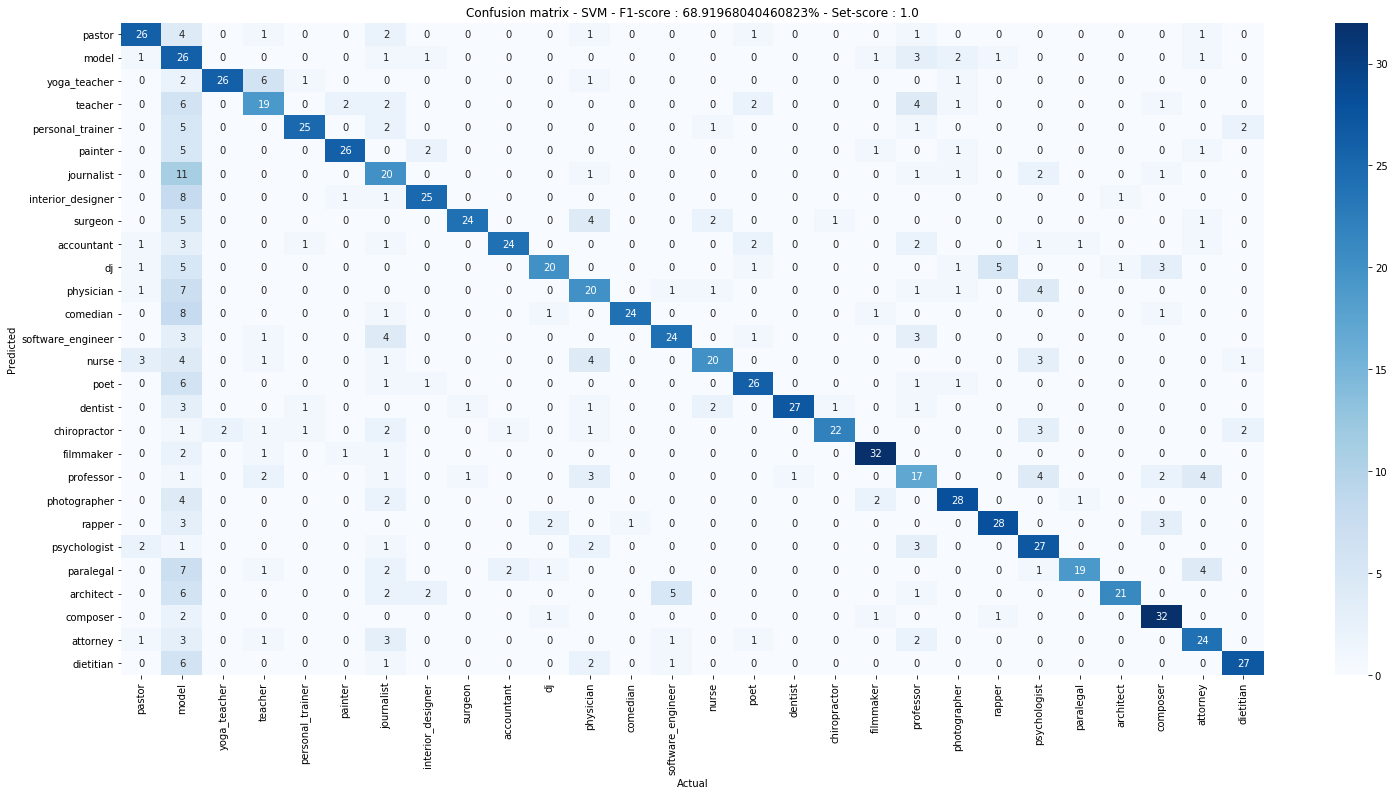

In [19]:
show_conf_matrix(ft_ep_test, lb_ep_test, svc_model, "EQP", 'SVM', df_info_genre, df_job)

##### `31.B.b.2` Dataframe équilibré en proportion de catégories de métiers

In [20]:
svc_model.fit(ft_e_train,lb_e_train)

svc_model_pred = svc_model.predict(ft_e_test)

# Training f1-score))

plt.show()
print("The training f1-score is: ")
print(f1_score(lb_e_train, svc_model.predict(ft_e_train), average="macro"))

# Test f1-score
print("The test f1-score is: ")
print(f1_score(lb_e_test, svc_model_pred, average="macro"))

# show_most_informative_features(tfidf, svc_model, 10)

The training f1-score is: 
0.988891949392787
The test f1-score is: 
0.741263665852938


In [21]:
df_score_model = model_score_dataframe(lb_e_test, lb_e_train, ft_e_test, ft_e_train, "EQI", df_info_genre, tfidf,'TF-IDF', svc_model,'SVM')
df_scores = pd.concat([df_scores,df_score_model])

In [22]:
df_score_model

Classifier  Training Set F1-Score  Test Set F1-Score  \
0        SVM               0.988892           0.741264   

   Job Proportion Max Gap  Female/Male Ratio  Female/Male per Job Max Gap  \
0                0.000065           0.738344                     0.844189   

  Vectorizer Training Set Shape Test Set Shape  \
0     TF-IDF     (15346, 36878)  (6578, 36878)   

                                   Vectorizer Params  \
0  {'analyzer': 'word', 'binary': False, 'decode_...   

                     Preprocess  \
0  CLEN, STEM, LEMM, LOWC, STPW   

                                   Classifier Params  
0  {'C': 1.0, 'break_ties': False, 'cache_size': ...

###### Rapport de classification

In [23]:
print(classification_report(lb_e_test,svc_model_pred))

              precision    recall  f1-score   support

           0       0.69      0.83      0.75       235
           1       0.43      0.78      0.55       235
           2       0.90      0.84      0.87       235
           3       0.37      0.56      0.45       235
           4       0.84      0.76      0.80       234
           5       0.80      0.84      0.82       235
           6       0.50      0.71      0.59       235
           7       0.81      0.77      0.79       235
           8       0.90      0.74      0.81       235
           9       0.80      0.75      0.77       235
          10       0.82      0.76      0.79       235
          11       0.58      0.64      0.61       235
          12       0.83      0.71      0.76       235
          13       0.65      0.79      0.71       234
          14       0.85      0.68      0.75       235
          15       0.81      0.71      0.76       235
          16       0.97      0.78      0.86       235
          17       0.95    

###### Matrice de confusion

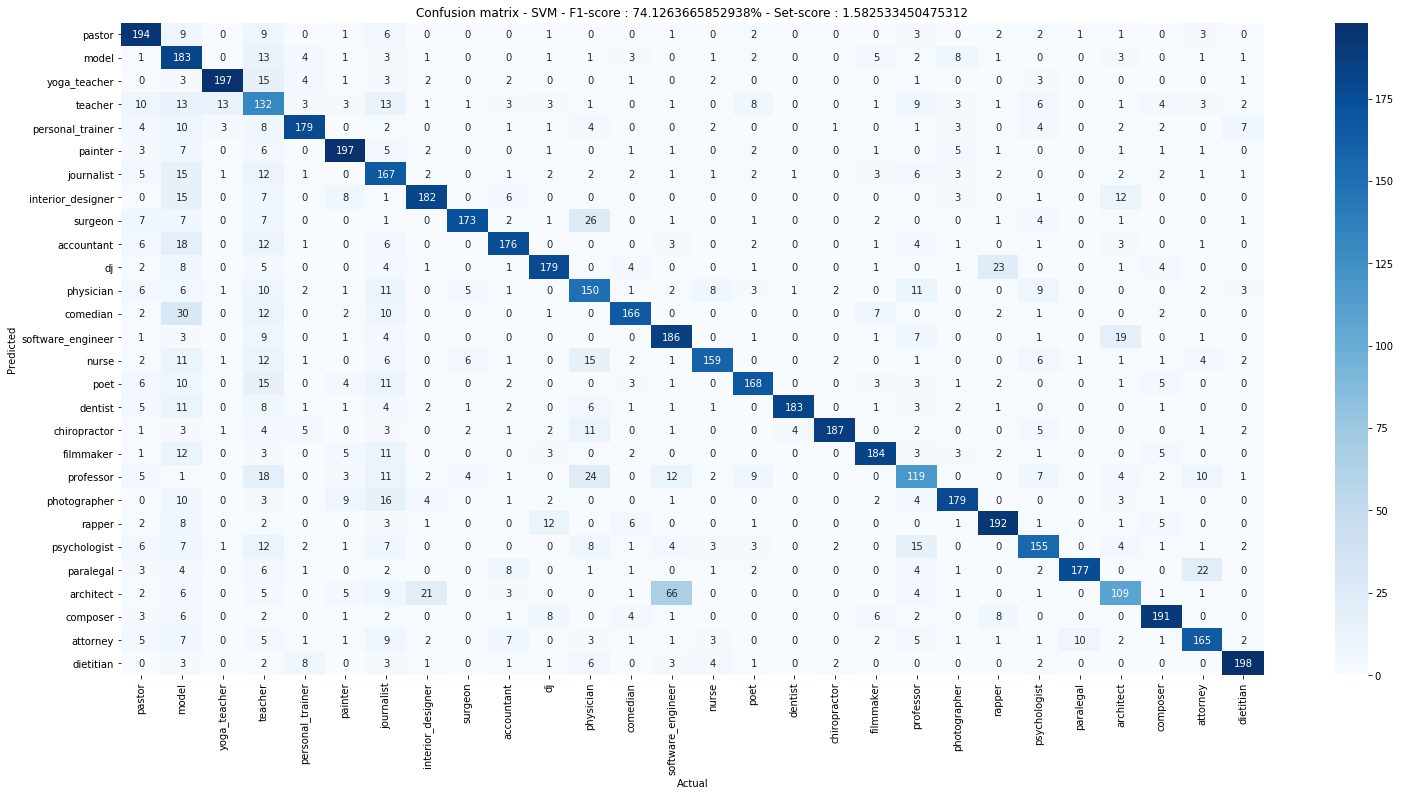

In [24]:
show_conf_matrix(ft_e_test, lb_e_test, svc_model, "EQI", 'SVM', df_info_genre, df_job)

##### `31.B.b.3` Dataframe paritaire

In [26]:
# Les tests ici sont vraiment trop loooooong
svc_model.fit(ft_p_train,lb_p_train)

svc_model_pred = svc_model.predict(ft_p_test)

# Training f1-score
print("The training f1-score is: ")
print(f1_score(lb_p_train, svc_model.predict(ft_p_train), average="macro"))

# Test f1-score
print("The test f1-score is: ")
print(f1_score(lb_p_test, svc_model_pred, average="macro"))

# show_most_informative_features(tfidf, svc_model, 10)

The training f1-score is: 
0.6856291680288489
The test f1-score is: 
0.6126517887605514
0 pastor
	-2.0143	sesmad         		5.7540	candl          
	-1.1564	miss           		5.6770	matricul       
	-1.0981	diwali         		4.2506	oriana         
	-0.9611	apison         		4.2417	evamaefarm     
	-0.9434	cuizin         		3.9534	kitchenwar     
	-0.8533	katelyn        		3.9165	raban          
	-0.8362	nau            		3.6676	dokument       
	-0.8283	glocol         		3.4268	basad          
	-0.7790	mattila        		3.3927	cftr           
	-0.7731	foll           		3.1536	camlinh        
1 model
	-2.7129	sfra           		11.0988	kolbasina      
	-2.3205	rogowicz       		4.0600	anglim         
	-2.2910	sesmad         		3.3018	dormanc        
	-1.8024	betalevel      		2.9384	babylon        
	-1.6966	artificium     		2.6234	jbvamc         
	-1.6759	ceará          		2.6069	nnole          
	-1.6757	diwali         		2.5808	mg             
	-1.5933	glocol         		2.5379	esri           
	-1.5915	cui

In [27]:
df_score_model = model_score_dataframe(lb_p_test, lb_p_train, ft_p_test, ft_p_train, "PAR", df_info_genre, tfidf,'TF-IDF', svc_model,'SVM')
df_scores = pd.concat([df_scores,df_score_model])

In [28]:
df_score_model

Classifier  Training Set F1-Score  Test Set F1-Score  \
0  SVM               0.685629           0.612652   

   Job Proportion Max Gap  Female/Male Ratio  Female/Male per Job Max Gap  \
0                0.400809                1.0                          0.0   

  Vectorizer Training Set Shape   Test Set Shape  \
0     TF-IDF   (109536, 112034)  (46944, 112034)   

                                   Vectorizer Params  \
0  {'analyzer': 'word', 'binary': False, 'decode_...   

                     Preprocess  \
0  CLEN, STEM, LEMM, LOWC, STPW   

                                   Classifier Params  
0  {'C': 1.0, 'class_weight': None, 'dual': False...

###### Rapport de classification

In [29]:
print(classification_report(lb_p_test,svc_model_pred))

              precision    recall  f1-score   support

           0       0.57      0.25      0.35       216
           1       0.80      0.46      0.58       430
           2       0.62      0.35      0.45        85
           3       0.58      0.56      0.57      2235
           4       0.82      0.62      0.71       218
           5       0.83      0.79      0.81      1279
           6       0.65      0.79      0.71      3674
           7       0.81      0.22      0.35        98
           8       0.72      0.43      0.54       534
           9       0.86      0.61      0.72       677
          10       0.85      0.37      0.52        75
          11       0.79      0.76      0.78      2749
          12       0.90      0.51      0.65       207
          13       0.76      0.40      0.53       368
          14       0.90      0.58      0.70       677
          15       0.76      0.67      0.71      1283
          16       0.95      0.89      0.92      1137
          17       0.88    

###### Matrice de confusion

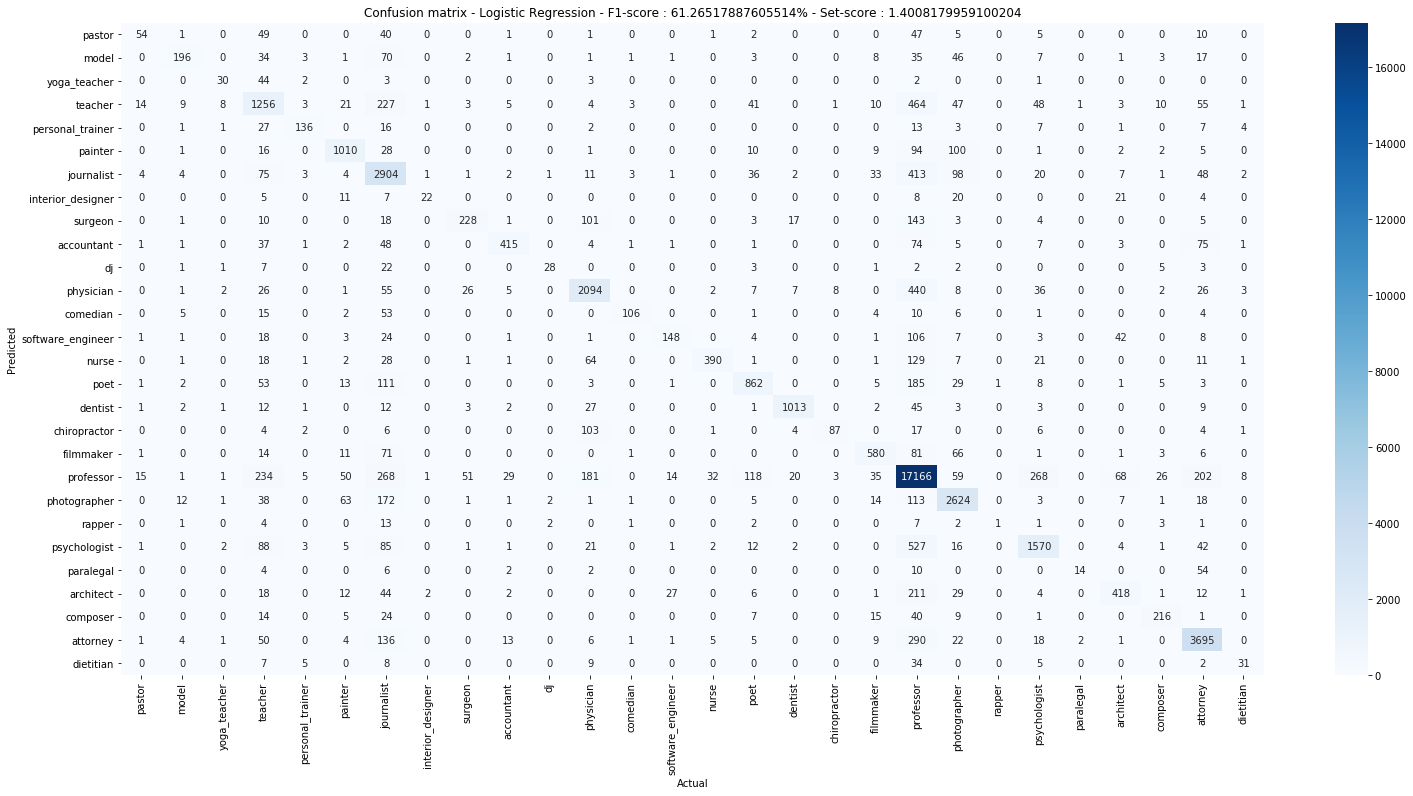

In [30]:
show_conf_matrix(ft_p_test, lb_p_test, svc_model, "PAR", 'SVM', df_info_genre, df_job)

##### `31.B.b.4` Dataframe paritaire et voulu équilibré en proportion de catégories de métiers

In [25]:
svc_model.fit(ft_mp_train,lb_mp_train)


svc_model_pred = svc_model.predict(ft_mp_test)

# Training f1-score
print("The training f1-score is: ")
print(f1_score(lb_mp_train, svc_model.predict(ft_mp_train), average="macro"))

# Test f1-score
print("The test f1-score is: ")
print(f1_score(lb_mp_test, svc_model_pred, average="macro"))

# show_most_informative_features(tfidf, svc_model, 10)

The training f1-score is: 
0.9876506062040177
The test f1-score is: 
0.6383456944246829


In [26]:
df_score_model = model_score_dataframe(lb_mp_test, lb_mp_train, ft_mp_test, ft_mp_train, "MIP", df_info_genre, tfidf,'TF-IDF', svc_model,'SVM')
df_scores = pd.concat([df_scores,df_score_model])

In [27]:
df_score_model

Classifier  Training Set F1-Score  Test Set F1-Score  \
0        SVM               0.987651           0.638346   

   Job Proportion Max Gap  Female/Male Ratio  Female/Male per Job Max Gap  \
0                0.053373                1.0                          0.0   

  Vectorizer Training Set Shape Test Set Shape  \
0     TF-IDF      (8094, 25172)  (3470, 25172)   

                                   Vectorizer Params  \
0  {'analyzer': 'word', 'binary': False, 'decode_...   

                     Preprocess  \
0  CLEN, STEM, LEMM, LOWC, STPW   

                                   Classifier Params  
0  {'C': 1.0, 'break_ties': False, 'cache_size': ...

###### Rapport de classification

In [28]:
print(classification_report(lb_mp_test,svc_model_pred))

              precision    recall  f1-score   support

           0       0.86      0.68      0.76       119
           1       0.88      0.33      0.48        92
           2       0.82      0.76      0.79        74
           3       0.28      0.69      0.40       212
           4       0.93      0.86      0.89       212
           5       0.78      0.88      0.83       221
           6       0.40      0.80      0.54       214
           7       0.81      0.64      0.71        91
           8       0.88      0.46      0.60        63
           9       0.83      0.73      0.78       145
          10       0.86      0.54      0.67        68
          11       0.65      0.60      0.63       167
          12       0.94      0.54      0.69        91
          13       0.40      0.05      0.10        37
          14       0.87      0.36      0.51        36
          15       0.84      0.79      0.81       220
          16       0.99      0.66      0.79       131
          17       0.94    

###### Matrice de confusion

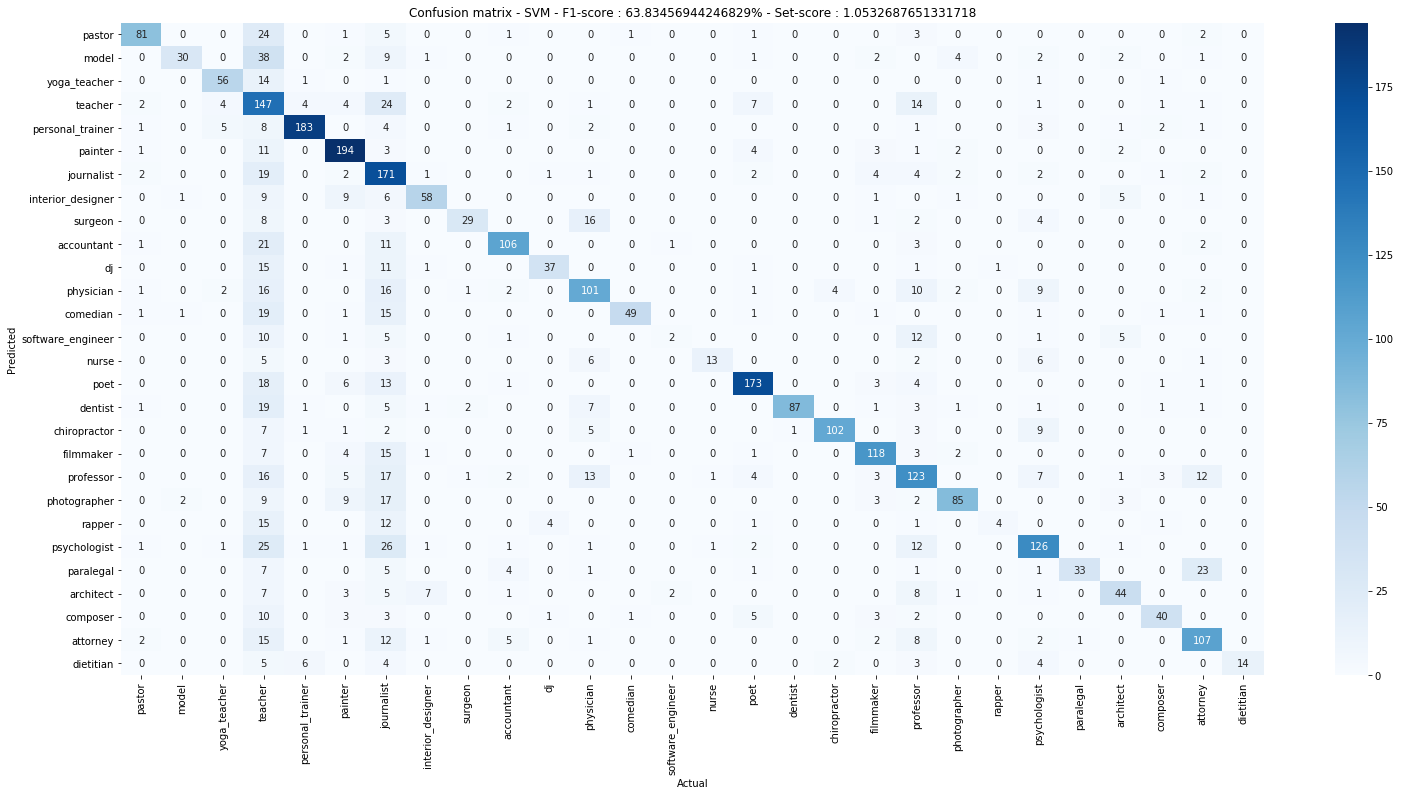

In [29]:
show_conf_matrix(ft_mp_test, lb_mp_test, svc_model, "MIP", 'SVM', df_info_genre, df_job)

##### `31.B.b.5` Dataframe brut

In [36]:
svc_model.fit(ft_train,lb_train)

svc_model_pred = svc_model.predict(ft_test)

# Training f1-score
print("The training f1-score is: ")
print(f1_score(lb_train, svc_model.predict(ft_train), average="macro"))

# Test f1-score
print("The test f1-score is: ")
print(f1_score(lb_test, svc_model_pred, average="macro"))

# show_most_informative_features(tfidf, svc_model, 10)

The training f1-score is: 
0.7906777603243917
The test f1-score is: 
0.7285849987547469
0 pastor
	-3.1181	work           		7.5398	pastor         
	-1.5802	project        		5.8304	ministri       
	-1.5577	practic        		5.2867	church         
	-1.5052	research       		5.2798	seminari       
	-1.3439	health         		5.1682	theolog        
	-1.3142	dr             		5.1570	christian      
	-1.2988	client         		5.1217	god            
	-1.2900	art            		5.0479	congreg        
	-1.2422	artist         		5.0273	faith          
	-1.1980	patient        		4.5600	bibl           
1 model
	-3.7037	write          		12.8477	model          
	-2.7900	book           		5.0408	bear           
	-2.7622	com            		4.9066	miss           
	-2.6826	univers        		4.8956	fashion        
	-2.5549	author         		4.5943	appear         
	-2.3954	practic        		4.5881	freeon         
	-2.3926	client         		4.3111	playboy        
	-2.3193	research       		4.2520	runway         
	-2.2723	dr 

In [37]:
df_score_model = model_score_dataframe(lb_test, lb_train, ft_test, ft_train, "RAW", df_info_genre, tfidf,'TF-IDF', svc_model,'SVM')
df_scores = pd.concat([df_scores,df_score_model])

In [38]:
df_score_model

Classifier  Training Set F1-Score  Test Set F1-Score  \
0  SVM               0.790678           0.728585   

   Job Proportion Max Gap  Female/Male Ratio  Female/Male per Job Max Gap  \
0                0.318758           0.841386                     0.853147   

  Vectorizer Training Set Shape   Test Set Shape  \
0     TF-IDF   (152037, 137029)  (65160, 137029)   

                                   Vectorizer Params  \
0  {'analyzer': 'word', 'binary': False, 'decode_...   

                     Preprocess  \
0  CLEN, STEM, LEMM, LOWC, STPW   

                                   Classifier Params  
0  {'C': 1.0, 'class_weight': None, 'dual': False...

###### Rapport de classification

In [39]:
print(classification_report(lb_test,svc_model_pred))

              precision    recall  f1-score   support

           0       0.66      0.52      0.58       449
           1       0.79      0.73      0.76      1235
           2       0.77      0.61      0.68       283
           3       0.57      0.57      0.57      2744
           4       0.78      0.60      0.68       242
           5       0.81      0.78      0.80      1386
           6       0.64      0.74      0.69      3689
           7       0.74      0.51      0.61       257
           8       0.82      0.68      0.74      1985
           9       0.84      0.67      0.74       936
          10       0.92      0.53      0.67       249
          11       0.72      0.71      0.72      3482
          12       0.86      0.64      0.73       492
          13       0.71      0.65      0.68      1218
          14       0.88      0.79      0.84      3787
          15       0.75      0.67      0.71      1288
          16       0.94      0.91      0.92      1635
          17       0.88    

###### Matrice de confusion

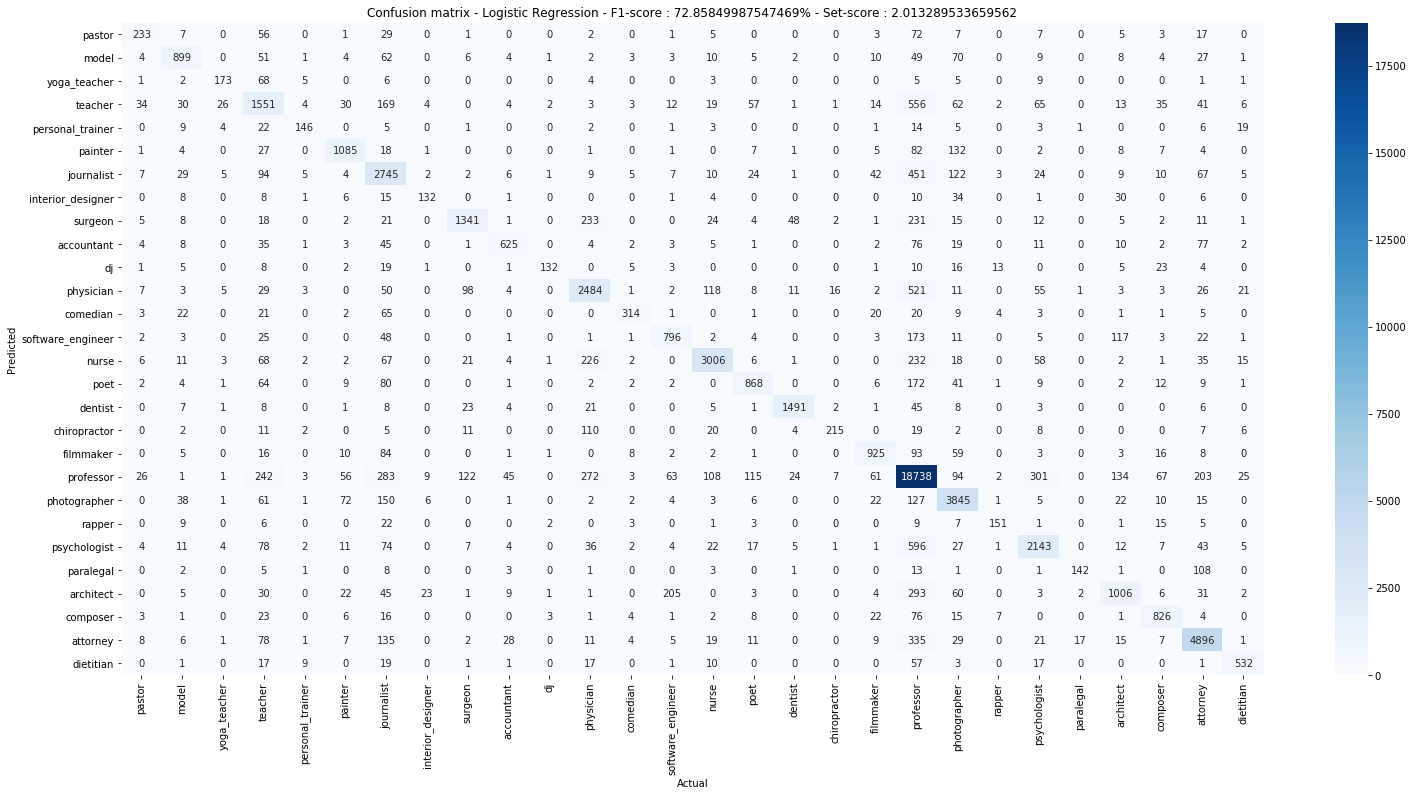

In [40]:
show_conf_matrix(ft_test, lb_test, svc_model, "RAW", 'SVM', df_info_genre, df_job)

### `32.B.` Comparaison des scores du classifieur - _`SVM`_

In [30]:
df_scores

Classifier  Training Set F1-Score  Test Set F1-Score  \
0  Logistic Regression               0.950876           0.693362   
0  Logistic Regression               0.882137           0.748109   
0  Logistic Regression               0.685629           0.612652   
0  Logistic Regression               0.851504           0.666419   
0  Logistic Regression               0.790678           0.728585   
0  K Nearest Neighbors               0.708248           0.566894   
0  K Nearest Neighbors               0.746222           0.617361   
0  K Nearest Neighbors               0.746222           0.617361   
0  K Nearest Neighbors               0.715828           0.574088   
0                  SVM               0.998329           0.689197   
0                  SVM               0.988892           0.741264   
0                  SVM               0.987651           0.638346   

   Job Proportion Max Gap  Female/Male Ratio  Female/Male per Job Max Gap  \
0                0.000418           1.000000                     0.000000   
0                0.000065           0.738344                     0.844189   
0                0.400809           1.000000                     0.000000   
0                0.053373           1.000000                     0.000000   
0                0.318758           0.841386                     0.853147   
0                0.000418           1.000000                     0.000000   
0                0.000065           0.738344                     0.844189   
0                0.000065           0.738344                     0.844189   
0                0.053373           1.000000                     0.000000   
0                0.000418           1.000000                     0.000000   
0                0.000065           0.738344                     0.844189   
0                0.053373           1.000000                     0.000000   

  Vectorizer Training Set Shape   Test Set Shape  \
0     TF-IDF      (2391, 12607)    (1025, 12607)   
0     TF-IDF     (15346, 36878)    (6578, 36878)   
0     TF-IDF   (109536, 112034)  (46944, 112034)   
0     TF-IDF      (8094, 25172)    (3470, 25172)   
0     TF-IDF   (152037, 137029)  (65160, 137029)   
0     TF-IDF      (2391, 12607)    (1025, 12607)   
0     TF-IDF     (15346, 36878)    (6578, 36878)   
0     TF-IDF     (15346, 36878)    (6578, 36878)   
0     TF-IDF      (8094, 25172)    (3470, 25172)   
0     TF-IDF      (2391, 12607)    (1025, 12607)   
0     TF-IDF     (15346, 36878)    (6578, 36878)   
0     TF-IDF      (8094, 25172)    (3470, 25172)   

                                   Vectorizer Params  \
0  {'analyzer': 'word', 'binary': False, 'decode_...   
0  {'analyzer': 'word', 'binary': False, 'decode_...   
0  {'analyzer': 'word', 'binary': False, 'decode_...   
0  {'analyzer': 'word', 'binary': False, 'decode_...   
0  {'analyzer': 'word', 'binary': False, 'decode_...   
0  {'analyzer': 'word', 'binary': False, 'decode_...   
0  {'analyzer': 'word', 'binary': False, 'decode_...   
0  {'analyzer': 'word', 'binary': False, 'decode_...   
0  {'analyzer': 'word', 'binary': False, 'decode_...   
0  {'analyzer': 'word', 'binary': False, 'decode_...   
0  {'analyzer': 'word', 'binary': False, 'decode_...   
0  {'analyzer': 'word', 'binary': False, 'decode_...   

                     Preprocess  \
0  CLEN, STEM, LEMM, LOWC, STPW   
0  CLEN, STEM, LEMM, LOWC, STPW   
0  CLEN, STEM, LEMM, LOWC, STPW   
0  CLEN, STEM, LEMM, LOWC, STPW   
0  CLEN, STEM, LEMM, LOWC, STPW   
0  CLEN, STEM, LEMM, LOWC, STPW   
0  CLEN, STEM, LEMM, LOWC, STPW   
0  CLEN, STEM, LEMM, LOWC, STPW   
0  CLEN, STEM, LEMM, LOWC, STPW   
0  CLEN, STEM, LEMM, LOWC, STPW   
0  CLEN, STEM, LEMM, LOWC, STPW   
0  CLEN, STEM, LEMM, LOWC, STPW   

                                   Classifier Params  
0  {'C': 1.0, 'class_weight': None, 'dual': False...  
0  {'C': 1.0, 'class_weight': None, 'dual': False...  
0  {'C': 1.0, 'class_weight': None, 'dual': False...  
0  {'C': 1.0, 'class_weight': None, 'dual':

Nous retiendrons donc le set `EQI` avec un _f1-score_ de  **74%**.

_**Remarque** : Le temps d'exécution de ce classifieur est très long pour les sets de plus de 10 000 données._


### `33.B.` Export des dataframes en pickles
On va pouvoir passer au notebook suivant en y important nos dataframes nouvellement formés.

In [31]:
now = dt.datetime.now()
datm = "{}{}{}{}{}{}".format(now.year,now.month,now.day,now.hour,now.minute,now.second)

In [10]:
# SVM - svc_model
with open(f'{path}3. Model Training/Pickles/{datm}.svc_model.pickle', 'wb') as output:
    pickle.dump(svc_model, output)

In [32]:
# Dataframe des scores - df_scores
with open(f'{path}3. Model Training/Pickles/{datm}.df_scores.pickle', 'wb') as output:
    pickle.dump(df_scores, output)

### `34.B.` Sources
* [TfidfVectorizer SciKit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.get_params)